In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! kaggle datasets download -d khoongweihao/covid19-xray-dataset-train-test-sets

 95% 80.0M/84.3M [00:00<00:00, 77.5MB/s]
100% 84.3M/84.3M [00:00<00:00, 108MB/s] 


In [ ]:
import zipfile
zf = "/content/covid19-xray-dataset-train-test-sets.zip"
target_dir = "/content/dataset/cnn/pneumonia_revamped"
zfile = zipfile.ZipFile(zf)
zfile.extractall(target_dir)

In [ ]:
#Some Basic Imports
import matplotlib.pyplot as plt #For Visualization
import numpy as np              #For handling arrays
import pandas as pd             # For handling data
#Define Directories for train, test & Validation Set
train_path = '/content/dataset/cnn/pneumonia_revamped/xray_dataset_covid19/train'
test_path = '/content/dataset/cnn/pneumonia_revamped/xray_dataset_covid19/test'
valid_path = '/content/dataset/cnn/pneumonia_revamped/xray_dataset_covid19/test'
#Define some often used standard parameters
#The batch refers to the number of training examples utilized in one #iteration
batch_size = 16 
#The dimension of the images we are going to define is 500x500 img_height = 500
img_height = 500
img_width = 500
#The dimension size of 500 or more than 500 with batch size greater than 16 may result in a crash as the RAM gets completely used in such cases. A lower dimension size with greater batch size is one of the options to try.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Create Image Data Generator for Train Set
image_gen = ImageDataGenerator(
                                  rescale = 1./255,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  horizontal_flip = True,          
                               )
# Create Image Data Generator for Test/Validation Set
test_data_gen = ImageDataGenerator(rescale = 1./255)

In [ ]:
train = image_gen.flow_from_directory(
      train_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      class_mode='binary',
      batch_size=batch_size
      )
test = test_data_gen.flow_from_directory(
      test_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      shuffle=False, 
#setting shuffle as False just so we can later compare it with predicted values without having indexing problem 
      class_mode='binary',
      batch_size=batch_size
      )
valid = test_data_gen.flow_from_directory(
      valid_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      class_mode='binary', 
      batch_size=batch_size
      )

Found 148 images belonging to 2 classes.
Found 40 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


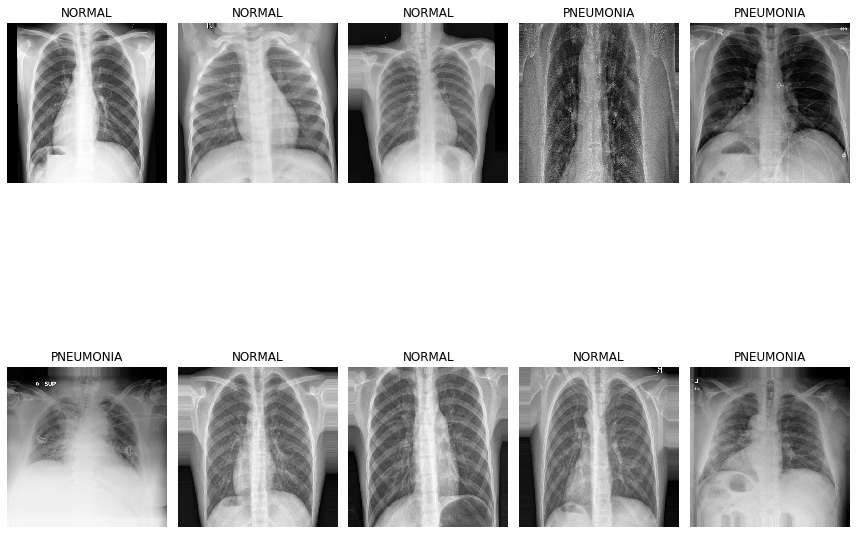

In [ ]:
plt.figure(figsize=(12, 12))
for i in range(0, 10):
    plt.subplot(2, 5, i+1)
    for X_batch, Y_batch in train:
        image = X_batch[0]        
        dic = {0:'NORMAL', 1:'PNEUMONIA'}
        plt.title(dic.get(Y_batch[0]))
        plt.axis('off')
        plt.imshow(np.squeeze(image),cmap='gray',interpolation='nearest')
        break
plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

In [ ]:
cnn = Sequential()
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(128, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Flatten())
cnn.add(Dense(activation = 'relu', units = 128))
cnn.add(Dense(activation = 'relu', units = 64))
cnn.add(Dense(activation = 'sigmoid', units = 1))
cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 498, 498, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 249, 249, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 247, 247, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 123, 123, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 121, 121, 128)     73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 60, 60, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 460800)            0

**Interpreting Model Summary**

In [ ]:
# Hyperparameters of Conv2D
Conv2D(
    filters=32,
    kernel_size=3,
    strides=(1, 1),
    padding="valid",
    activation=None,
    input_shape=(500,500,1)
    )
# Hyperparameters of MaxPooling2D 
MaxPooling2D(
    pool_size=(2, 2), strides=None, padding="valid"
    )

The input shape of the images are (500,500,1) as we defined the height & width earlier. And the 1 represents the color channel as the images are grayscale the color channel for it is 1 and for rgb images it is 3.
(none,500,500,1) Over here Keras adds an extra dimension none since batch size can vary.

In First Conv2d layer Convolution operation on image of (500,500) with a (3,3) kernel size with strides and dilation set 1 by default and padding set to ‘valid’, it spits out output size of (500-3+1 , 500-3+1 ) = (498,498) And the number of filters we defined is 32, the output shape is now(None,498,498,32)

Now in the first Max Pooling layer, we have defined the kernel size as (2,2) and strides are by default (2,2) applying that to input of image size of (498,498) we get ((498–2//2)+1,(498–2//2)+1))= (249,249)

The Flatten layer takes all of the pixels along all channels and creates a 1D vector without considering batchsize. The input of (13, 13, 64) is therefore flattened to (13*13*64) = 10816 values.

The parameter value is calculated by (kernel_height * kernel_width * input_channels * output_channels) + (output_channels) which gives (3*3*1*32)+(32) = 320 in first layer.

The rectified linear activation function or short-term ReLU is a piecewise linear function that outputs the input directly if it is positive, otherwise it outputs zero. The rectified linear activation function overcomes the problem of vanishing gradients, allowing models to learn faster and perform better.

Padding — "SAME": output size is the same as input size. This requires the filter window to slip outside input map, hence the need to pad."VALID": Filter window stays at valid position inside input map, so output size shrinks by filter_size - 1. No padding occurs.

Activation function — Simply put, activation is a function that is added to an artificial neural network to help the network learn complex patterns in the data. When comparing with a neuron-based model in our brains, the activation function is at the end of the day to decide what to do with the next neuron. Since the classification is between 2 classes we are going to use sigmoid activation function for last layer which returns value in the range of 0 to 1. For more than 2 classes we can use softmax activation function.

**Visualize CNN model**

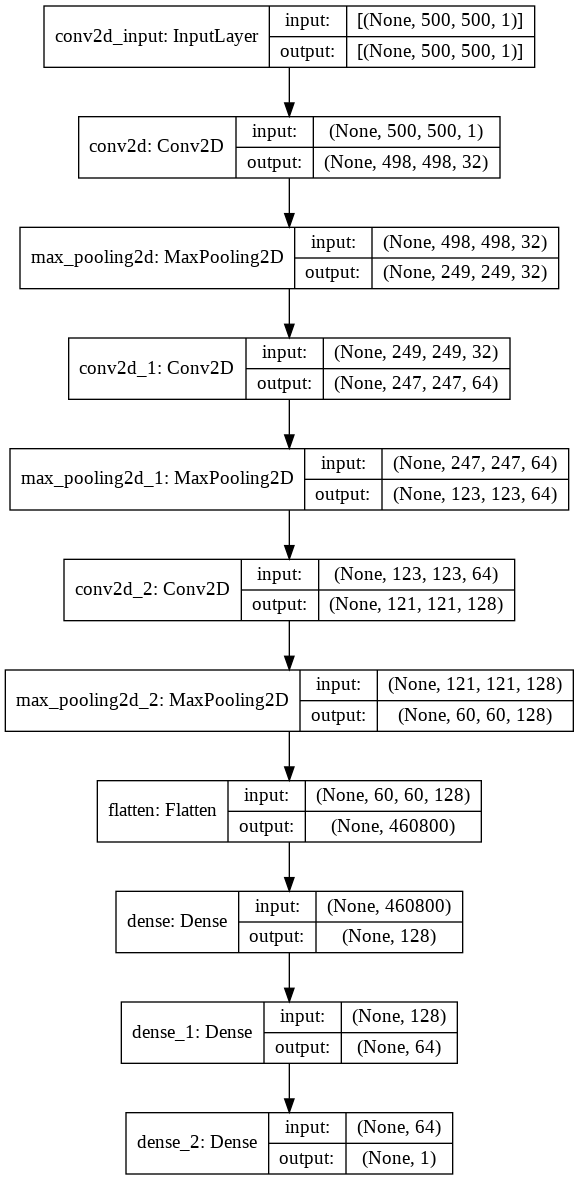

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(cnn,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True) #By default, graphs are laid out from top to bottom ("TB").

**Defining the callback list**

EarlyStopping is called to stop the epochs based on some metric(monitor) and conditions (mode, patience) . It helps to avoid overfitting the model. Over here we are telling to stop based on val_loss metric, we need it to be minimum. patience says that after a minimum val_loss is achieved then after that in next iterations if the val_loss increases in any the 3 iterations then the the training will stop at that epoch.
Reduce learning rate when a metric has stopped improving. Models often benefit from reducing the learning rate by a factor of 2–10 once learning stagnates. This callback monitors a quantity and if no improvement is seen for a ‘patience’ number of epochs, the learning rate is reduced.

In [ ]:
early = EarlyStopping(monitor="val_loss", mode="min", patience=3)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
callbacks_list = [ early, learning_rate_reduction]

* Patience: the number of epochs with no improvement after which learning rate will be reduced.

* reduceLROnPlateau: Reduce learning rate when a metric has stopped improving. Models often benefit from reducing the learning rate by a 
factor of 2-10 once learning stagnates. This callback monitors a quantity and if no improvement is seen for a 'patience' number of epochs, the learning rate is reduced. It helps to avoid overfitting the model.

* Patience: factor by which the learning rate will be reduced.
* min_lr: lower bound on the learning rate.
* Verbose:  int. 0: quiet, 1: update messages.
* Monitor: quantity to be monitored.


**Assign class weights**

It is good practice to assign class weights for each class. It emphasizes the weight of the minority class in order for the model to learn from all classes equally.

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight('balanced', np.unique(train.classes), train.classes)
cw = dict(zip( np.unique(train.classes), weights))
print(cw)

{0: 1.0, 1: 1.0}


In [ ]:
cnn.fit(train, epochs=5, validation_data=valid, class_weight=cw, callbacks = callbacks_list)

Epoch 1/5
10/10 [==============================] - 85s 9s/step - loss: 1.9125 - accuracy: 0.4706 - val_loss: 0.7041 - val_accuracy: 0.5000
Epoch 2/5
10/10 [==============================] - 82s 8s/step - loss: 0.6848 - accuracy: 0.5494 - val_loss: 0.5406 - val_accuracy: 0.9750
Epoch 3/5
10/10 [==============================] - 81s 8s/step - loss: 0.5021 - accuracy: 0.8801 - val_loss: 0.1473 - val_accuracy: 0.9750
Epoch 4/5
10/10 [==============================] - 82s 8s/step - loss: 0.3613 - accuracy: 0.8347 - val_loss: 0.1100 - val_accuracy: 0.9500
Epoch 5/5
10/10 [==============================] - 83s 8s/step - loss: 0.2229 - accuracy: 0.9328 - val_loss: 0.1570 - val_accuracy: 0.9750


**Visualize the accuracy of the CNN model**

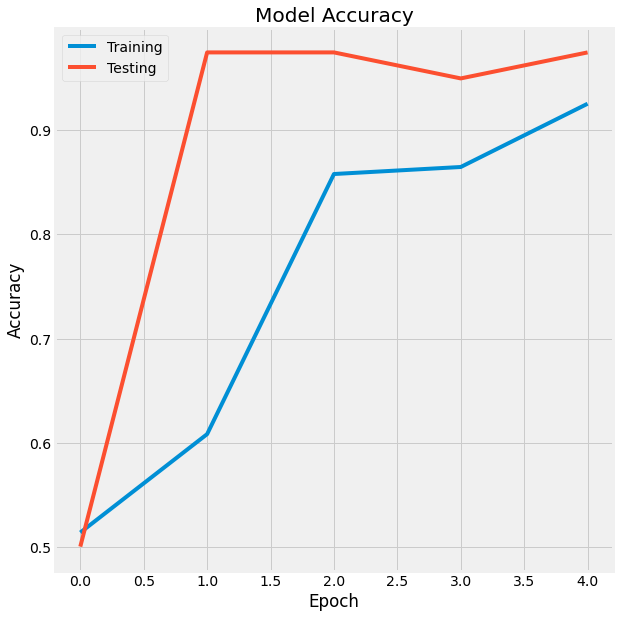

In [ ]:
plt.figure(figsize=(10,10))
plt.style.use('fivethirtyeight')

plt.plot(cnn.history.history['accuracy'])
plt.plot(cnn.history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])

plt.show()

**Visualize the loss of the CNN**

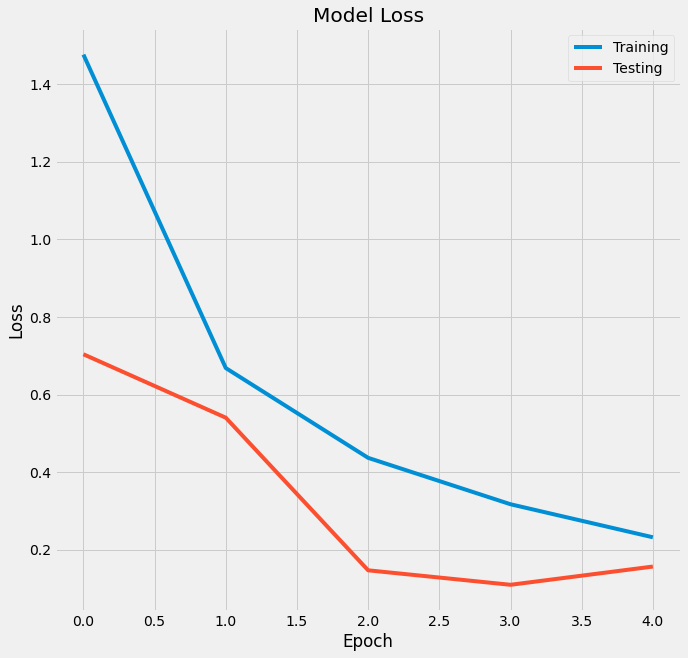

In [ ]:
plt.figure(figsize=(10,10))
plt.style.use('fivethirtyeight')

plt.plot(cnn.history.history['loss'])
plt.plot(cnn.history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])

plt.show()

**Testing the accuracy**

In [ ]:
test_accu = cnn.evaluate(test)
print('The testing accuracy is :',test_accu[1]*100, '%')

3/3 [==============================] - 5s 1s/step - loss: 0.1269 - accuracy: 0.9750
The testing accuracy is : 97.50000238418579 %


Let’s predict the test dataset and look at some of the performance measurement metrics in detail to evaluate our model.

In [ ]:
preds = cnn.predict(test,verbose=1)

3/3 [==============================] - 6s 2s/step


Since the activation function of the last layer is sigmoid, the model gives prediction in the 0 to 1 range and not an exact classification as 0 or 1. So we categorise all the values in the 0.5 to 1 range as 0 and less than 0.5 as 1. Note(0 denotes a normal case and 1 denotes a case of pneumonia)

In [ ]:
predictions = preds.copy()
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

**Confusion Matrix**

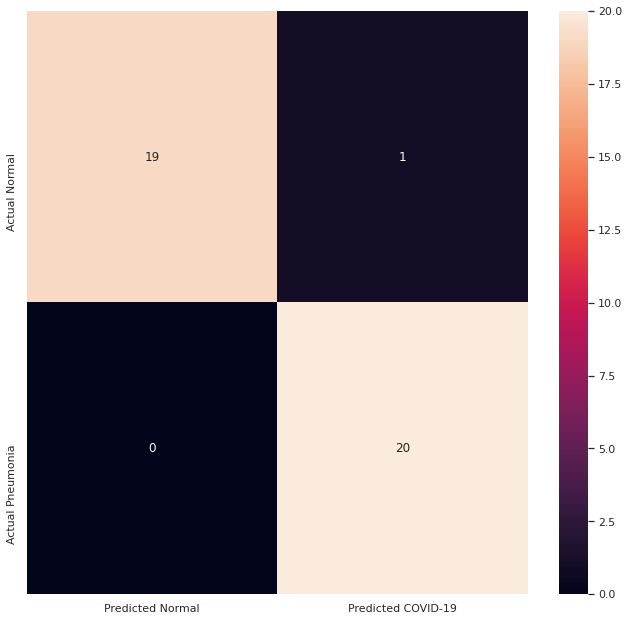

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
cm = pd.DataFrame(data=confusion_matrix(test.classes, predictions, labels=[0, 1]),index=["Actual Normal", "Actual Pneumonia"],
columns=["Predicted Normal", "Predicted COVID-19"])
import seaborn as sns
sns.heatmap(cm,annot=True,fmt="d")
# sns.figure(figsize=(20, 20))
sns.set(rc={'figure.figsize':(5,10)})

**Classification report**

* Precision = TruePositives / (TruePositives + FalsePositives)

* Recall = TruePositives / (TruePositives + FalseNegatives)

* F1 = (2 * Precision * Recall) / (Precision + Recall)

In [ ]:
print(classification_report(y_true=test.classes, y_pred=predictions,
                            target_names =['NORMAL','PNEUMONIA']
 ))

              precision    recall  f1-score   support

      NORMAL       0.95      1.00      0.98        20
   PNEUMONIA       1.00      0.95      0.97        20

    accuracy                           0.97        40
   macro avg       0.98      0.97      0.97        40
weighted avg       0.98      0.97      0.97        40



In [ ]:
# test.reset()
# x=np.concatenate([test.next()[0] for i in range(test.__len__())])
# y=np.concatenate([test.next()[1] for i in range(test.__len__())])
# print(x.shape)
# print(y.shape)
# #this little code above extracts the images from test Data iterator without shuffling the sequence
# # x contains image array and y has labels 
# dic = {0:'NORMAL', 1:'PNEUMONIA'}
# plt.figure(figsize=(20,20))
# for i in range(0+228, 9+228):
#   plt.subplot(3, 3, (i-228)+1)
#   if preds[i, 0] >= 0.5: 
#       out = ('{:.2%} probability of being Pneumonia case'.format(preds[i][0]))
      
      
#   else: 
#       out = ('{:.2%} probability of being Normal case'.format(1-preds[i][0]))
# plt.title(out+"\n Actual case : "+ dic.get(y[i]))    
# plt.imshow(np.squeeze(x[i]))
# plt.axis('off')
# plt.show()

This code block gives a percentage prediction of the individual image that can be loaded directly from your drive by specifying its path.
We have to re-create all the data preprocessing steps over here after importing the image as we had done previously to feed the test set into the model to get prediction. For pre-processing we need to import tensorflow.keras.preprocessing.image class.
Import image and define dimensions as (500,500) and color channel as grayscale.
Convert image to array, rescale it by dividing it 255 and expand dimension by axis = 0 as our model takes 4 dimensions as seen earlier.
Finally let’s predict the case!

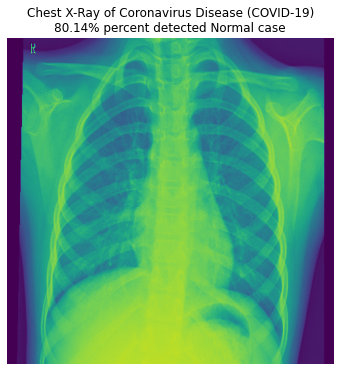

In [ ]:
# Testing with my own Chest X-Ray
hardik_path = '/content/dataset/cnn/pneumonia_revamped/xray_dataset_covid19/test/NORMAL/NORMAL2-IM-0111-0001.jpeg'

from tensorflow.keras.preprocessing import image

hardik_img = image.load_img(hardik_path, target_size=(500, 500),color_mode='grayscale')

# Preprocessing the image
pp_hardik_img = image.img_to_array(hardik_img)
pp_hardik_img = pp_hardik_img/255
pp_hardik_img = np.expand_dims(pp_hardik_img, axis=0)

#predict
hardik_preds= cnn.predict(pp_hardik_img)

#print
plt.figure(figsize=(6,6))
plt.axis('off')
if hardik_preds>= 0.5: 
    out = ('{:.2%} percent detected COVID-19 Pneumonia'.format(hardik_preds[0][0]))
    
else: 
    out = ('{:.2%} percent detected Normal case'.format(1-hardik_preds[0][0]))
    

plt.title("Chest X-Ray of Coronavirus Disease (COVID-19)\n"+out)  
plt.imshow(np.squeeze(pp_hardik_img))
plt.show()
